# This notebook plots the model that will be fit to your data. The model is the product of a Voigt emission line with self-reversal and two Voigt absorption lines representing the ISM attenuation, convolved with the STIS line spread function (LSF).

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from scipy.io import readsav
import lyapy 
from astropy.modeling.models import Voigt1D
import matplotlib as mpl



plt.ion()

rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)


label_size = 16
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size


rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

rc('text.latex', preamble=r'\usepackage[helvet]{sfmath}')

plt.rcParams.update(mpl.rcParamsDefault)

In [218]:
## let's create a wavelength array to use
wave_lya = np.arange(1214.5,1217.,0.001) # Angstroms

In [219]:
## let's define the model parameters - try changing these around and running all the subsequent cells

# radial velocity of the star in km/s (reasonable range: -300 to +300)
vs = 12.919641231348859

# logarithm of the amplitude of the Lorentzian (emission line) in erg/cm2/s/A (reasonable range: -13 to -9)
am = -13.728543837943922

# FWHM of the Lorentzian in km/s (reasonable range: ~5-100)
fw_L = 0.3.

# FWHM of the Gaussian in km/s (reasonable range: ~10-200)
fw_G = 50.

# logarithm of the ISM H I column density in cm^{-2} (reasonable range: 17.5 to 19.0)
h1_col = 17.8 

# Doppler broadening parameter in km/s (reasonable range: 6-15)
h1_b = 11.5

# radial velocity of the ISM absorbers (km/s) (reasonable range: -40 to +40)
h1_vel = 0

### the following parameters allow for additional ISM absorption - 
### I've set the column density to zero so there is no additional ISM absorption
h1_col2, h1_b2, h1_vel2 = 0, 11.5, 0

# D/H ratio (deuterium to hydrogen ratio) - we fix this value almost always because 
# our data generally don't constrain it well.
d2h = 1.5e-5

# self-absorption parameter "p" (unitless) - (reasonable range: 0-3)
p = 1.5



SyntaxError: invalid syntax (1980108224.py, line 10)

In [ ]:
# Calculate the intrinsic stellar emission line
line_center = vs/3e5*1215.67+1215.67 # convert km/s to Angstroms
sigma_G = fw_G/3e5 * 1215.67 # convert km/s to Angstroms
sigma_L = fw_L/3e5 * 1215.67 # convert km/s to Angstroms
                                           

voigt_profile_func = Voigt1D(x_0 = line_center, amplitude_L = 10**am, 
                                                fwhm_L = sigma_L, fwhm_G = sigma_G)

rev_profile = np.exp(-p * voigt_profile_func(wave_lya) / np.max(voigt_profile_func(wave_lya)))

lya_intrinsic_profile = voigt_profile_func(wave_lya) * rev_profile 


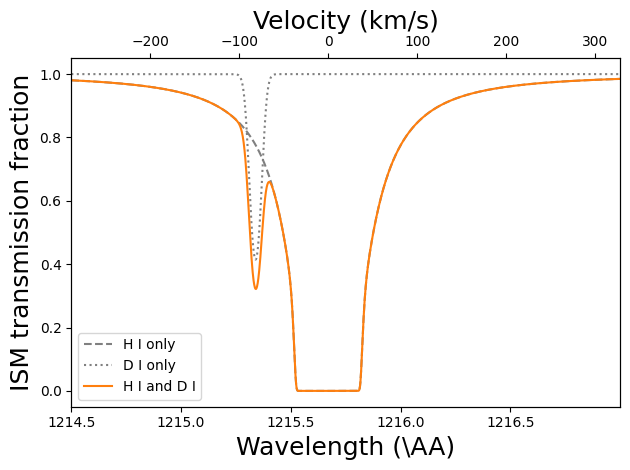

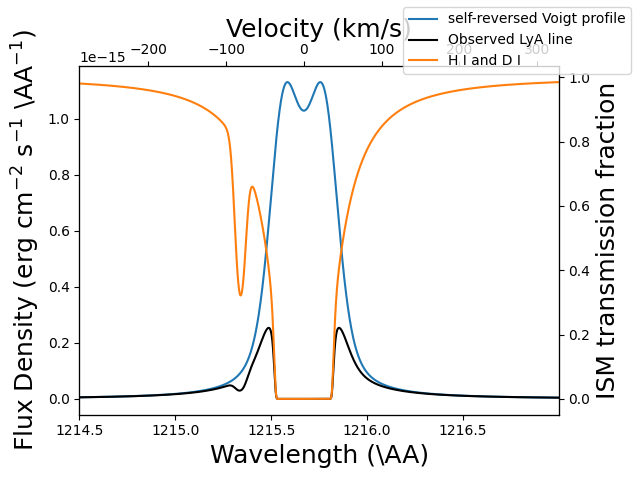

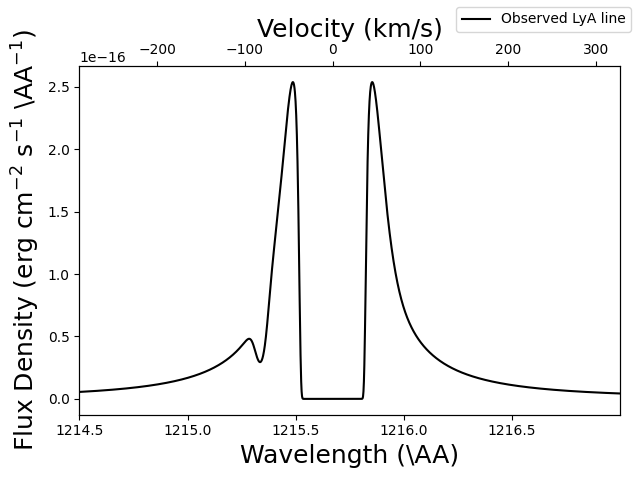

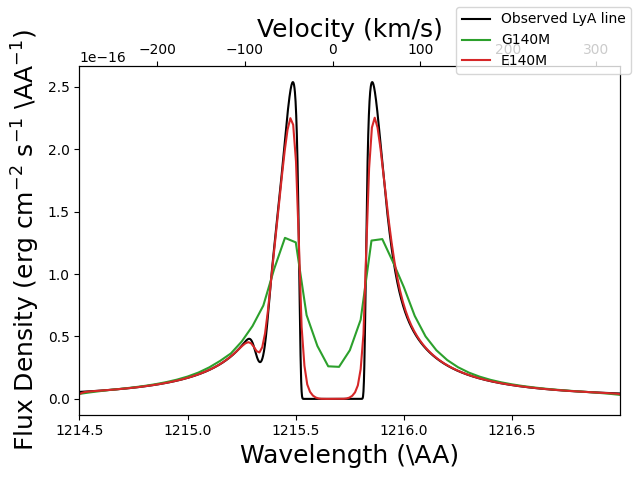

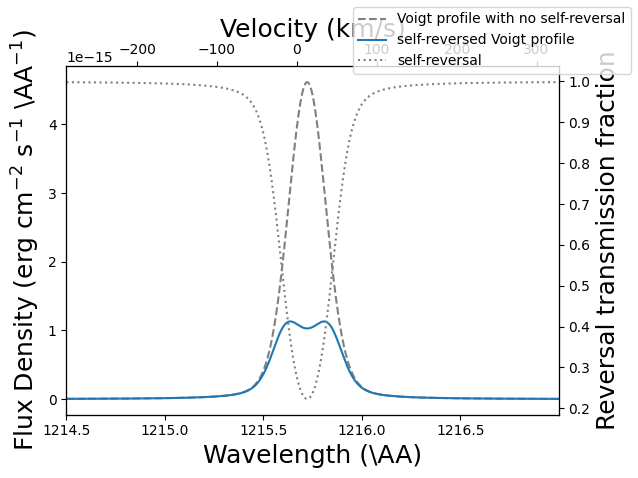

In [ ]:
# Check if latex is installed


# plot the intrinsic stellar emission line

fig=plt.figure()
ax = fig.add_subplot(111)
ax_rev = ax.twinx()
ax_vel = ax.twiny()

ax.plot(wave_lya, voigt_profile_func(wave_lya), linestyle='--', color='grey', 
               label='Voigt profile with no self-reversal')
ax_rev.plot(wave_lya, rev_profile, linestyle=':', color='grey',label='self-reversal')

ax.plot(wave_lya,lya_intrinsic_profile,color='C0',label='self-reversed Voigt profile')

ax.set_xlabel('Wavelength (\AA)',fontsize=18)
ax.set_ylabel('Flux Density (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)',fontsize=18)
ax_rev.set_ylabel('Reversal transmission fraction',fontsize=18)

xlim = np.array([np.min(wave_lya),np.max(wave_lya)])
xlim_vel = (xlim - 1215.67)/1215.67*2.998e5
ax.set_xlim(xlim)
ax_vel.set_xlim(xlim_vel)
ax_vel.set_xlabel('Velocity (km/s)',fontsize=18)
fig.legend()

fig.tight_layout()
plt.show()


In [ ]:
# Calculate the ISM absorption profile

total_attenuation_h1 = lyapy.total_tau_profile_func(wave_lya,
                                               h1_col,h1_b,h1_vel,d2h,which_line='h1')
d1_col = np.log10((10**h1_col) * d2h)
total_attenuation_d1 = lyapy.total_tau_profile_func(wave_lya,
                                               d1_col,h1_b/np.sqrt(2),h1_vel,d2h,which_line='d1')

total_attenuation = lyapy.total_tau_profile_func(wave_lya,
                                               h1_col,h1_b,h1_vel,d2h)
#total_attenuation2 = lyapy.total_tau_profile_func(wave_lya,
#                                               h1_col2,h1_b2,h1_vel2,d2h) - let's just ignore total_attenuation2
fig = plt.figure()
ax = fig.add_subplot(111)
ax_vel = ax.twiny()

ax.plot(wave_lya,total_attenuation_h1,color='grey',linestyle='--',label='H I only')
ax.plot(wave_lya,total_attenuation_d1,color='grey',linestyle=':',label='D I only')


ax.plot(wave_lya,total_attenuation,color='C1',label='H I and D I')

ax.set_xlabel('Wavelength (\AA)',fontsize=18)
ax.set_ylabel('ISM transmission fraction',fontsize=18)

xlim = np.array([np.min(wave_lya),np.max(wave_lya)])
xlim_vel = (xlim - 1215.67)/1215.67*2.998e5
ax.set_xlim(xlim)
ax_vel.set_xlim(xlim_vel)
ax_vel.set_xlabel('Velocity (km/s)',fontsize=18)

ax.legend()


fig.tight_layout()

In [ ]:
## adding the components together to create the observed emission line

fig = plt.figure()
ax = fig.add_subplot(111)
ax_ISM = ax.twinx()
ax_vel = ax.twiny()

y_model_lya = lya_intrinsic_profile * total_attenuation #* total_attenuation2

ax.plot(wave_lya,lya_intrinsic_profile,color='C0',label='self-reversed Voigt profile')
ax_ISM.plot(wave_lya,total_attenuation,color='C1',label='H I and D I')

ax.plot(wave_lya,y_model_lya,color='k',label='Observed LyA line')

xlim = np.array([np.min(wave_lya),np.max(wave_lya)])
xlim_vel = (xlim - 1215.67)/1215.67*2.998e5
ax.set_xlim(xlim)
ax_vel.set_xlim(xlim_vel)
ax_vel.set_xlabel('Velocity (km/s)',fontsize=18)

ax_ISM.set_ylabel('ISM transmission fraction',fontsize=18)

ax.set_xlabel('Wavelength (\AA)',fontsize=18)
ax.set_ylabel('Flux Density (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)',fontsize=18)

fig.legend()


fig.tight_layout()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax_vel = ax.twiny()

ax.plot(wave_lya,y_model_lya,color='k',label='Observed LyA line')

xlim = np.array([np.min(wave_lya),np.max(wave_lya)])
xlim_vel = (xlim - 1215.67)/1215.67*2.998e5
ax.set_xlim(xlim)
ax_vel.set_xlim(xlim_vel)
ax_vel.set_xlabel('Velocity (km/s)',fontsize=18)

ax.set_xlabel('Wavelength (\AA)',fontsize=18)
ax.set_ylabel('Flux Density (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)',fontsize=18)

fig.legend()


fig.tight_layout()

In [ ]:
### the next step is to bin the model to the STIS dispersion (Angstroms/pixel) and 
### convolve y_model_lya with the appropriate STIS grating line spread function (LSF).
### we want the model on the same wavelength grid as the data and we want the model
### to have the same spectral resolution as the data.

### At Lyman alpha, the STIS dispersions are 0.6 Å/pix (G140L), 0.05 Å/pix (G140M), 
### 0.013 Å/pix (E140M), or 0.0053 Å/pix (E140H). G140M and E140M are the most commonly
### used modes. https://www.stsci.edu/hst/instrumentation/stis/instrument-design/gratings--prism

g140m_disp = 0.05
e140m_disp = 0.013


In [ ]:
# define some example data wavelength grids
G140M_wave = np.arange(np.min(wave_lya),np.max(wave_lya)+g140m_disp,g140m_disp)
E140M_wave = np.arange(np.min(wave_lya),np.max(wave_lya)+e140m_disp,e140m_disp)

In [ ]:
### read in and set up STScI LSFs https://www.stsci.edu/hst/instrumentation/stis/performance/spectral-resolution

## G140M
lsf_filename = 'lsf/LSF_G140M_1200.dat'
lsf = np.loadtxt(lsf_filename,skiprows=2) 
lsf_wave = lsf[:,0]
lsf_array = lsf[:,2] ## pick one of the apertures - should be appropriate for your data. Doesn't matter
                    ## for this example
lsf_list = [lsf_wave,lsf_array]
resolution = [lsf_list]
kernel_for_convolution = lyapy.ready_stis_lsf(resolution[0][0],resolution[0][1],g140m_disp,G140M_wave)
resolution_lya_g140m = kernel_for_convolution.copy()



## E140M
lsf_filename = 'lsf/LSF_E140M_1200.dat'
lsf = np.loadtxt(lsf_filename,skiprows=2)
lsf_wave = lsf[:,0]
lsf_array = lsf[:,3] ## pick one of the apertures - should be appropriate for your data. Doesn't matter
                    ## for this example
lsf_list = [lsf_wave,lsf_array]
resolution = [lsf_list]
kernel_for_convolution = lyapy.ready_stis_lsf(resolution[0][0],resolution[0][1],e140m_disp,E140M_wave)
resolution_lya_e140m = kernel_for_convolution.copy()

In [ ]:
# linearly interpolate y_model_lya onto these grids
y_model_lya_g140m = np.interp(G140M_wave,wave_lya,y_model_lya)
y_model_lya_e140m = np.interp(E140M_wave,wave_lya,y_model_lya)

In [ ]:
# convolve with appropriate LSF
y_model_lya_g140m_convolved = np.convolve(y_model_lya_g140m,resolution_lya_g140m,mode='same')
y_model_lya_e140m_convolved = np.convolve(y_model_lya_e140m,resolution_lya_e140m,mode='same')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax_vel = ax.twiny()

ax.plot(wave_lya,y_model_lya,color='k',label='Observed LyA line')
ax.plot(G140M_wave,y_model_lya_g140m_convolved,color='C2',label='G140M')
ax.plot(E140M_wave,y_model_lya_e140m_convolved,color='C3',label='E140M')

xlim = np.array([np.min(wave_lya),np.max(wave_lya)])
xlim_vel = (xlim - 1215.67)/1215.67*2.998e5
ax.set_xlim(xlim)
ax_vel.set_xlim(xlim_vel)
ax_vel.set_xlabel('Velocity (km/s)',fontsize=18)

ax.set_xlabel('Wavelength (\AA)',fontsize=18)
ax.set_ylabel('Flux Density (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)',fontsize=18)

fig.legend()


fig.tight_layout()